## Paolo's code refactoring from Syed's original

In [3]:
import pandas as pd
import numpy as np
import pickle
import math
from os.path import exists

import matplotlib.colors as mcolors
from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns
from wordcloud import WordCloud

# Gensim
import gensim
import gensim.corpora as corpora
# from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# t-SNE and Bokeh vis
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models

# Progress bar
from tqdm.notebook import tqdm

# Word Counter
from collections import Counter


import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import pprint
pp = pprint.PrettyPrinter(indent=4)
import scipy.stats as ss
import itertools

# Pre-Processing

In [4]:
DATA_PATH= '/Users/npm65/OneDrive - Newcastle University/NIHR-AI-MLTC-M/DATA/'
WD = '/Users/npm65/OneDrive - Newcastle University/NIHR-AI-MLTC-M/CODE/cluster-assignments/MLTC-Patient_modelling/'

LTC_BINARY = DATA_PATH+'ltc_matrix_binary_mm4.tsv'
BOWs = WD+'data/BOWs.pkl'
TERMS_REL_WEIGHTS_IDF = WD+'data/terms_rel_weights_idf.csv'
LDA_MODEL = WD+'data/lda_model.pkl'
ALL_TRAJECTORIES = WD+'data/trajectories.pkl'
BOWID2BOW  = WD+'data/BowId2bow.pkl'


# Common Functions

## from the binary matrix, create the bag of words to feed LDA

In [5]:
## from `ltc_patients` create `list_of_patients` if it does not exist
def create_bows(bin_matrix):
    list_of_patients = []

    patients = bin_matrix['patient_id'].unique()
    ltcs = bin_matrix.drop('patient_id', axis = 1)
    index = 0

    # Iterate through patients
    for patient in patients:

        # Start with empty list of LTCs for each patient
        patient_ltcs = []

        # Iterate through each LTC for patient
        for ltc in ltcs:

            # Check if patient has LTC
            if bin_matrix.at[index, ltc] == 1:

                # If LTC present, add to list of patient LTCs
                patient_ltcs.append(ltc)   

        # Add list of patient LTCs to list of patients        
        list_of_patients.append(patient_ltcs)

        # Increment index by 1
        index+=1

    ## cache for future use
    with open(BOWs, 'wb') as f:
        pickle.dump(list_of_patients, f)
        
    return list_of_patients


# Topics generation

In [6]:
# in: bow is the list of bag of words
# in: topics_count is the number of topics to be generated
# returns lda-model

def bagOfWords2Topics(bow, topics_count):
    id2word = corpora.Dictionary(bows)

    corpus = []
    for text in list_of_patients:
        new = id2word.doc2bow(text)
        corpus.append(new)

    lda_model =  gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=topics_count,
                                           workers=3,
                                           random_state=100,
                                           chunksize=500,
                                           passes=10,
                                           alpha="asymmetric",
                                           eta=1.0)
    ## cache for future use
    with open(LDA_MODEL, 'wb') as f:
        pickle.dump(lda_model, f)
        
    return lda_model


In [7]:
# compute the probabilities of each bow relative to each topic

def compute_all_bow_probabilities(lda_model):
    # Will store topic similarity score for each of the patients in our corpus
    lda_res_each_ptnt = []

    ## for each bag of words used to generate the topics:
    for i in bows:
        bow = id2word.doc2bow(i)
        lda_res_each_ptnt.append(lda_model[bow])  ## these are the probabilities for this document for each topic
        
    return lda_res_each_ptnt

In [8]:
# Build a dataframe with each term's relative weight within each topic
# in: lda_model

def compute_terms_topics_associations(lda_model):
    # Creating a matrix of disease/MLTC/word distribution within each cluster

    colnames_raw = ['MLTC', 'topic 1', 'topic 2', 'topic 3', 'topic 4']
    colnames_final = ['rwidf1', 'rwidf2', 'rwidf3', 'rwidf4']

    ## new df with one column per topic
    df_word_weightage_bytopic = pd.DataFrame(columns=colnames_raw)

    ## for each topic t
    for t in range(len(colnames_raw)):
        ## new df with schema [MLTC, topic_t]
        df_cal = pd.DataFrame(columns=['MLTC', colnames_raw[t+1]])  
        
        nm = list()
        dst = list()
        ## for each condition
        ## 
        for i in range(203):
            ## https://radimrehurek.com/gensim/models/ldamodel.html?highlight=show_topics#gensim.models.ldamodel.LdaModel.show_topics
            ## return list of {str, tuple of (str, float)}
            name, dist = lda_model.show_topics(num_words=203, formatted=False)[t][1][i]
            nm.append(name)   ## name of condition
            dst.append(dist)  ## scores of term for each topic
        df_cal[colnames_raw[t+1]] = dst
        df_cal['MLTC'] = nm
        df_cal.sort_values(by=['MLTC'], ignore_index=True, inplace=True)

        df_word_weightage_bytopic[colnames_raw[t+1]] = df_cal[colnames_raw[t+1]]
    df_word_weightage_bytopic['MLTC'] = df_cal['MLTC']

    print(df_word_weightage_bytopic.head)
    
    df_idf = df_word_weightage_bytopic.copy()

    # Calculating disease term frequency in our corpus
    disease_count = []

    for i in df_idf['MLTC']:
        count = 0
        for k in bows:
            if i in k:
                count = count +1            
        disease_count.append(count)

    df_idf['idf'] = disease_count

    # Calculating inverse document frequency
    for i in range(len(df_idf['idf'])):
        df_idf['idf'].loc[i] = math.log10(len(bows) / (df_idf['idf'].loc[i] + 1))
    df_idf[colnames_final[0]] = ''
    df_idf[colnames_final[1]] = ''
    df_idf[colnames_final[2]] = ''
    df_idf[colnames_final[3]] = ''

    # Calculating relative weight for each word/disease

    for i, rows in df_idf.iterrows():

        sum = rows[1]+rows[2]+rows[3]+rows[4]
        df_idf[colnames_final[0]][i] = rows[1]/(sum)
        df_idf[colnames_final[1]][i] = rows[2]/(sum)
        df_idf[colnames_final[2]][i] = rows[3]/(sum)
        df_idf[colnames_final[3]][i] = rows[4]/(sum)

    ## add word counts
    df = []

    for i in df_idf['MLTC']:
        count = 0
        for k in bows:
            if i in k:
                count = count +1            
        df.append(count)

    df_idf['word occurence in docs'] = df

    # Add IDF to the terms relative weights
    df_idf[colnames_final[0]] = df_idf[colnames_final[0]] * df_idf['idf']
    df_idf[colnames_final[1]] = df_idf[colnames_final[1]] * df_idf['idf']
    df_idf[colnames_final[2]] = df_idf[colnames_final[2]] * df_idf['idf']
    df_idf[colnames_final[3]] = df_idf[colnames_final[3]] * df_idf['idf']

    df_idf.sort_values(by=['idf'], ascending=False)
    
    ## cache for faster future use
    terms_topics_df.to_csv(TERMS_REL_WEIGHTS_IDF)    

    return df_idf


In [24]:
### Create a word cloud with calculated association strength (idf * relative weights)

def createWordClouds(df_idf):
    # Wordcloud of Top N LTCs for each topic based on association strength

    i = 1
    for j in df_idf.columns[6:10]:

        ltc_dic = pd.Series(df_idf[j].values,index=df_idf.MLTC).to_dict()

        colrs = [color for name, color in mcolors.TABLEAU_COLORS.items()]
        cloud = WordCloud(background_color='white',
                        width=2500,
                        height=1800,
                        max_words=10,
                        colormap='tab10',
                        color_func=lambda *args, **kwargs: colrs[i],
                        prefer_horizontal=1.0)

        topics = df_idf[[j]] # Since we have fixed the topics to 4, we can change this to make it dynamic

        if i < 9:
            # fig.add_subplot(ax)
            topic_words = ltc_dic
            cloud.generate_from_frequencies(topic_words, max_font_size=300)
            plt.gca().imshow(cloud)
            titl = 'Topic ' + str(j[-1])
            plt.gca().set_title(titl, fontdict=dict(size=16))
            plt.gca().axis('off')


        plt.subplots_adjust(wspace=0, hspace=0)
        plt.axis('off')
        plt.margins(x=0, y=0)
        plt.tight_layout()
        plt.show()
        i = i+1

        # fig.savefig("../images/topic0_relative_weight.png", dpi=60)


### compute the tensor that holds the patient-topic association __for incremental bag of terms in the patient's history__


In [105]:
# bream down a bow into its stages, for instance:
#  bow = ['OA', 'skin_ulcer', 'dermatitis']
#  stages = [['OA'], ['OA', 'skin_ulcer'], ['OA', 'skin_ulcer', 'dermatitis']]
def getStages(bow):
        stages = []
        for i in range(len(bow)):
            stage = stages.append(bow[0:i+1])
        return stages


# look up each term in bowStage. add up all partial association strength for each topic, generating an array of size K = number of topic
# def assoc(bowStage, rwidf):
def assoc(bowstage, rwidf):
    assocVector = np.zeros(topics_count)
    for term in bowstage:
        row = rwidf.loc[terms_topics_df['MLTC'] == term]
#         print(row[['rwidf1', 'rwidf2', 'rwidf3', 'rwidf4']])
        assocVector[0] += row['rwidf1']
        assocVector[1] += row['rwidf2']
        assocVector[2] += row['rwidf3']
        assocVector[3] += row['rwidf4']
    return assocVector

## main method to compute the 'tensor' as a nested dictionary:
# bows = list(bow)
# bow = list(bowStage)
# bowStage = list(term)
# term --> association vector of size K = number of topics
# so:
#    all_patients_traj = { id(bow): one_patient_trajectory}
#    one_patient_trajectory = { id(bowStage): assoc vector}
#  to use hashing we need to create an id for each bow (id=patient) and one id for each stage in that patient's history.
#  note that these are not the native patient IDs which are lost at this point
#
# return all_patients_traj
#
def computeTrajectoryAssociations(bows, rwidf):

    bowID2bow = dict()  ## need to use bowIDs as hash keys so this dict maps bowID to the actual bow content
    bowId = 1 # makes hashing possible
    all_patients_traj = dict()  ## top level dict
    
    for bow in bows:    # for each bag of word (each patient)
#         print("processing bowId {0}: [{1}]".format(bowId, bow))
        
        bowID2bow[bowId] = bow
        traj = all_patients_traj[bowId] = dict()  ## individual trajectory is itself a dict()
        bowStageId = 1
        for bowStage in getStages(bow):  # compute association vector for each of its stages
#             print("processing bowStage [{0}]".format(bowStage))
            
            traj[bowStageId]  = assoc(bowStage, rwidf)
#             print("vector for bowStageId [{0}]: {1}".format(bowStageId, traj[bowStageId]))
            bowStageId += 1
#         print("trajectory: {0}\n".format(traj))
        bowId += 1
        if bowId % 1000 == 0:
            print("{0} patients processed".format(bowId))
            
    ## save main trajectories data structure

    with open(ALL_TRAJECTORIES, 'wb') as f:
        pickle.dump(trajectories, f)

    with open(BOWID2BOW, 'wb') as f:
        pickle.dump(bowId2bow, f)

    return all_patients_traj, bowID2bow


def pprint(trajectory):
    for bowStageId in trajectory.keys():
        print("stage {0}: {1}".format(bowStageId, trajectory[bowStageId]))

In [95]:
### testing computeTrajectoryAssociations

bows = [['OA', 'skin_ulcer', 'dermatitis'], ['asthma', 'hypertension', 'hearing_loss', 'alcohol_depend']]

trajectories, bowId2bow = computeTrajectoryAssociations(bows, terms_topics_df)

print("bowId2bow: {0}\n".format(bowId2bow))

for bowId in bowId2bow:
    print("\ntrajectory for bowId {0} {1}:".format(bowId, bowId2bow[bowId])) 
    pprint(trajectories[bowId])


bowId2bow: {1: ['OA', 'skin_ulcer', 'dermatitis'], 2: ['asthma', 'hypertension', 'hearing_loss', 'alcohol_depend']}


trajectory for bowId 1 ['OA', 'skin_ulcer', 'dermatitis']:
stage 1: [0.19722805 0.20889193 0.08012044 0.03410168]
stage 2: [1.23590841 0.20936339 0.08058843 0.10037369]
stage 3: [1.70221034 0.20999013 0.08069319 0.10057065]

trajectory for bowId 2 ['asthma', 'hypertension', 'hearing_loss', 'alcohol_depend']:
stage 1: [8.02072300e-01 2.30789804e-04 2.65533177e-04 8.82547581e-04]
stage 2: [8.83824910e-01 1.58725864e-01 3.26779529e-04 1.66258446e-01]
stage 3: [1.20444848 0.55046823 0.02542478 0.1708882 ]
stage 4: [1.40688089 1.01865794 0.02669063 0.5875521 ]


# Pipeline execution

## from the binary matrix, create the bag of words to feed LDA

In [1]:
## use cached pickle file is available 

if exists(BOWs):
    with open(BOWs, 'rb') as f:
      bows =  pickle.load(f)
    print('loaded BOW list [{0}] from cache'.format(BOWs))
else:
    ltc_patients = pd.read_csv(LTC_BINARY, sep = '\t')
    bows = create_bows()
    
print("working with {0} bows (= patients)".format(len(bows)))

NameError: name 'exists' is not defined

### summary stats about our bags of words

In [42]:
all_len = 0

for text in bows:
    all_len += len(text)
    
avg_len = all_len/len(bows)

print("All words: {n}".format(n=all_len))
print("Average LTCs per patient: {n}".format(n=avg_len))
print("Maximum amount of LTCs: {n}".format(n= max(len(x) for x in bows)))
print("Minimum amount of LTCs: {n}".format(n= min(len(x) for x in bows)))
print("Patients in corpus: {l}".format(l=len(bows)))
print("Example of patient record:\n {n}".format(n=bows[1]))

All words: 1104514
Average LTCs per patient: 7.714810572194904
Maximum amount of LTCs: 37
Minimum amount of LTCs: 4
Patients in corpus: 143168
Example of patient record:
 ['female_genital_prolapse', 'fracture_hip', 'obesity', 'spondylosis', 'type_2_diabetes', 'unspecified_rare_diabetes', 'urine_incont']


### distribution of disease terms in the corpus

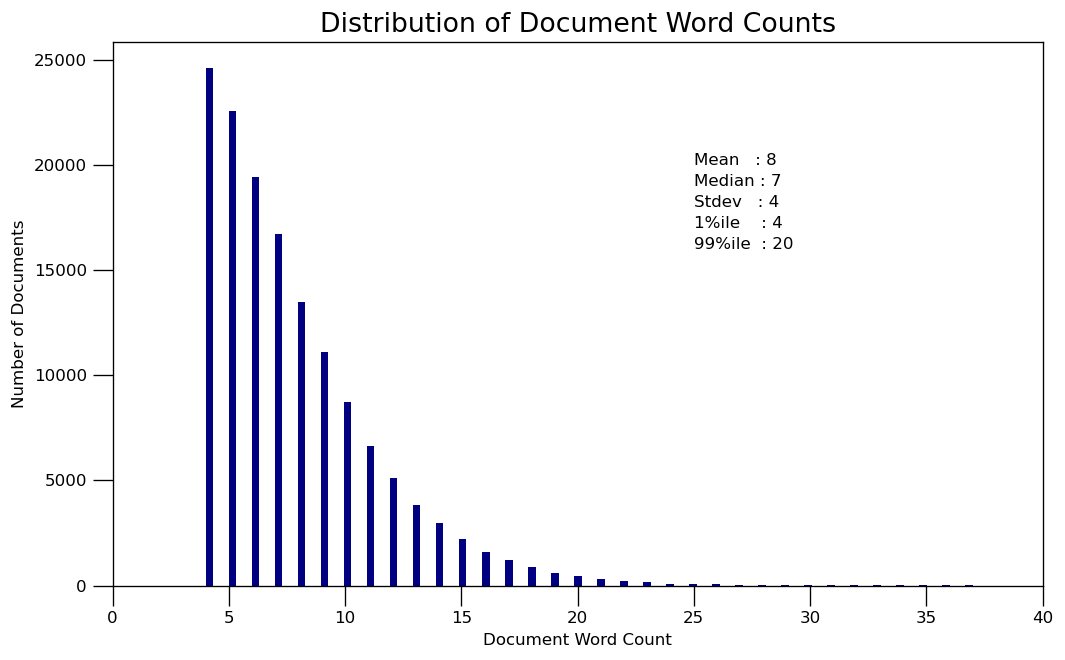

In [43]:
doc_lens = [len(d) for d in bows]

# Plot
plt.figure(figsize=(10,6), dpi=120)
plt.hist(doc_lens, bins = 100, color='navy')
plt.text(25, 20000, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(25,  19000, "Median : " + str(round(np.median(doc_lens))))
plt.text(25,  18000, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(25,  17000, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(25,  16000, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 40), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=12)
plt.xticks(np.linspace(0,40,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=16))
plt.show()

## Topics generation

### will iterate over multiple numbers of topics

## code needs to be generalised

In [44]:
topics_count = 4
# Note: num_topics attempted: 20, 15, 10, 5, 6, ,7 , 8, 4

### load / generate topic model

In [45]:
if exists(LDA_MODEL):
    with open(LDA_MODEL, 'rb') as f:
      lda_model = pickle.load(f)
      print('loaded model [{0}] from cache'.format(LDA_MODEL))
else:
    lda_model = bagOfWords2Topics(bows, topics_count)
    


loaded model [/Users/npm65/OneDrive - Newcastle University/NIHR-AI-MLTC-M/CODE/cluster-assignments/MLTC-Patient_modelling/data/lda_model.pkl] from cache


### compute all bag of words raw probabilities for each topic

(this does  not seem to be used again)

In [46]:
# lda_res_each_ptnt = compute_all_bow_probabilities(lda_model)

In [47]:
# lda results for each patients in a list form
# lda_res_each_ptnt[0:3]

### compute dataframe with rwidf association to each topic

this is the main dataframe we will use to track patient associations given their BOWs

In [2]:
## use cached pickle file is available 

if exists(TERMS_REL_WEIGHTS_IDF):
    with open(TERMS_REL_WEIGHTS_IDF, 'rb') as f:
      terms_topics_df = pd.read_csv(f)
      print('loaded terms_topics_df [{0}] from cache'.format(TERMS_REL_WEIGHTS_IDF))
else:
    terms_topics_df = compute_terms_topics_associations(lda_model)


terms_topics_df

NameError: name 'exists' is not defined

### generate word clouds for the topics

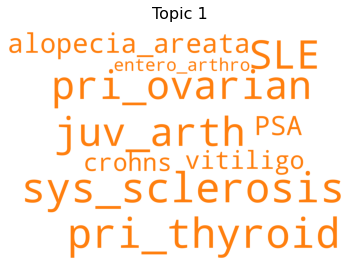

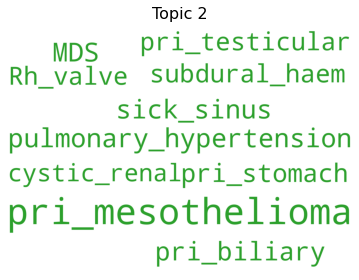

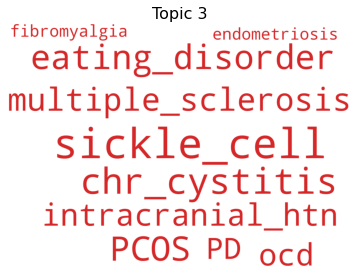

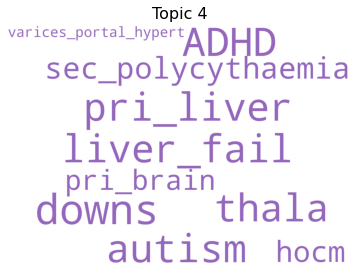

In [49]:
createWordClouds(terms_topics_df)

## compute the tensor that holds the patient-topic association __for each term in the patient's history__


In [98]:
## computing for all bows, the result is in the trajectories nesteed dict (see method def computeTrajectoryAssociations above)

len(bows)

2

In [104]:
# hist = ['OA', 'skin_ulcer', 'dermatitis', 'erectile_dysfunction', 'pri_skin']
# hist = ['OA', 'skin_ulcer', 'dermatitis']
# hist  = ['spondylosis', 'obesity', 'urine_incont', 'female_genital_prolapse', 'type_2_diabetes', 'unspecified_rare_diabetes', 'fracture_hip']
# hist = ['asthma', 'hypertension', 'hearing_loss', 'alcohol_depend']
# hist = ['venous_lymphatic', 'psoriasis', 'female_genital_prolapse', 'CHD', 'alcohol_depend', 'obesity', 'hearing_loss', 'urine_incont']
# hist = ['PTSD', 'COPD', 'neuro_bladder', 'female_genital_prolapse', 'OA'] 
# hist = ['dermatitis', 'hypertension', 'atrial_fibrilation', 'OA', 'tinnitus']

# bows = [['OA', 'skin_ulcer', 'dermatitis'],['asthma', 'hypertension', 'hearing_loss', 'alcohol_depend']]

if exists(ALL_TRAJECTORIES) and exists(BOWID2BOW):
    with open(ALL_TRAJECTORIES, 'rb') as f:
      trajectories =  pickle.load(f)
      print('loaded trajectories [{0}] from cache'.format(ALL_TRAJECTORIES))

    with open(BOWID2BOW, 'rb') as g:
      bowId2bow =  pickle.load(g)
      print('loaded bowId2bow [{0}] from cache'.format(BOWID2BOW))

else:
    print("starting computation of *all* trajectories for {0} bows (= patients)".format(len(bows)))
#     trajectories, bowId2bow = computeTrajectoryAssociations(bows, terms_topics_df)



loaded trajectories [/Users/npm65/OneDrive - Newcastle University/NIHR-AI-MLTC-M/CODE/cluster-assignments/MLTC-Patient_modelling/data/trajectories.pkl] from cache
loaded bowId2bow [/Users/npm65/OneDrive - Newcastle University/NIHR-AI-MLTC-M/CODE/cluster-assignments/MLTC-Patient_modelling/data/BowId2bow.pkl] from cache
